In [3]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import os, sys
import json

import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

Populating the interactive namespace from numpy and matplotlib


In [4]:
#sys.path.extend(['/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/arnie', '/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/'])
#os.environ["ARNIEFILE"] = '/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/arnie/run.arnie'
#sys.path.append('/mnt/c/Users/abreha.b/OneDrive - Stanford/rotations/das/DegScore')

sys.path.append('..')
import assign_loop_type
from assign_loop_type import write_loop_assignments


from DegScore import DegScore
from arnie.sample_structures import sample_structures

from tqdm.notebook import tqdm

## Code to reproduce DegScore from Kaggle datasets

In [54]:
def get_ensemble(sequence, n=1000):
    structs = sample_structures(sequence, n_samples=n, package='vienna')
    structs = [list(write_loop_assignments(s)) for s in structs]
    return np.array(structs)

def encode_input(df, window_size=1, pad=10, seq=True, struct=True, ensemble_size=0):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    seq (bool): include sequence encoding
    struct (bool): include bpRNA structure encoding
    
    Outputs:
    Input array (n_samples x n_features): array of windowed input features
    feature_names (list): feature names
    
    '''
    #MAX_LEN = 68
    BASES = ['A','U','G','C']
    STRUCTS = ['H','E','I','M','B','S']
    
    inpts = []
    labels = []

    feature_kernel=[]
    if seq:
        feature_kernel.extend(BASES)
    if struct:
        feature_kernel.extend(STRUCTS)

    feature_names = ['%s_%d' % (k, val) for val in range(-1*window_size, window_size+1) for k in feature_kernel]
    
    for i, row in tqdm(df.iterrows(), desc='Encoding inputs', total=len(df)):
        MAX_LEN = len(row['sequence'])-39
        
        arr = np.zeros([MAX_LEN,len(feature_kernel)])
        
        if ensemble_size > 0: # stochastically sample ensemble
            ensemble = get_ensemble(row['sequence'], n=ensemble_size)
        else: # use MEA structure
            ensemble = np.array([list(row['predicted_loop_type'])])

        for index in range(pad,MAX_LEN):
            ctr=0

            #encode sequence
            if seq:
                for char in BASES:
                    if row['sequence'][index]==char:
                        arr[index,ctr]+=1
                    ctr+=1

            if struct:
                loop_assignments = ''.join(ensemble[:,index])
                for char in STRUCTS:
                    prob = loop_assignments.count(char) / len(loop_assignments)
                    arr[index,ctr]+=prob
                    ctr+=1
                    
        # add zero padding to the side
        padded_arr = np.vstack([np.zeros([window_size,len(feature_kernel)]),arr[pad:], np.zeros([window_size,len(feature_kernel)])])

        for index in range(pad,MAX_LEN):
            new_index = index+window_size-pad
            tmp = padded_arr[new_index-window_size:new_index+window_size+1]
            inpts.append(tmp.flatten())
            labels.append('%s_%d' % (row['id'], index))
            
    return np.array(inpts), feature_names, labels

def encode_output(df, data_type='reactivity', pad=10):
    '''Creat input/output for regression model for predicting structure probing data.
    Inputs:
    
    dataframe (in EternaBench RDAT format)
    data_type: column name for degradation
    window_size: size of window (in one direction). so window_size=1 is a total window size of 3
    pad: number of nucleotides at start to not include
    
    Outputs:
    output array (n_samples): array of reactivity values
    
    '''
    #MAX_LEN = 68
    
    outpts = []
    labels = []
    # output identity should be in form id_00073f8be_0

    for i, row in df.iterrows():
        MAX_LEN = len(row['sequence'])-39
        
        for index in range(pad,MAX_LEN):
            outpts.append(row[data_type][index])
            labels.append('%s_%d' % (row['id'], index))
            
            
    return outpts, labels

#### Load data 

In [35]:
kaggle_train = pd.read_json('train.json',lines=True)
kaggle_train = kaggle_train.loc[kaggle_train['SN_filter']==1]

kaggle_test = pd.read_json('test.json',lines=True)
#kaggle_test = pd.read_csv('test_labels.csv')

In [36]:
kaggle_test

,index,id,sequence,structure,predicted_loop_type,seq_length,seq_scored
0,0,id_00073f8be,GGAAAAGUACGACUUGAGUACGGAAAACGUACCAACUCGAUUAAAA...,......((((((((((.(((((.....))))))))((((((((......,EEEEEESSSSSSSSSSBSSSSSHHHHHSSSSSSSSSSSSSSSSHHH...,107,68
1,1,id_000ae4237,GGAAACGGGUUCCGCGGAUUGCUGCUAAUAAGAGUAAUCUCUAAAU...,.....((((..((((((...(((((.....((((....)))).......,EEEEESSSSIISSSSSSIIISSSSSIIIIISSSSHHHHSSSSIIII...,130,91
2,2,id_00131c573,GGAAAACAAAACGGCCUGGAAGACGAAGGAAUUCGGCGCGAAGGCC...,...........((.(((.(.(..((..((..((((...))))..))...,EEEEEEEEEEESSISSSISISIISSIISSIISSSSHHHSSSSIISS...,107,68
3,3,id_00181fd34,GGAAAGGAUCUCUAUCGAAGGAUAGAGAUCGCUCGCGACGGCACGA...,......((((((((((....))))))))))((((((..((.(((.....,EEEEEESSSSSSSSSSHHHHSSSSSSSSSSSSSSSSIISSISSSHH...,107,68
4,4,id_0020473f7,GGAAACCCGCCCGCGCCCGCCCGCGCUGCUGCCGUGCCUCCUCUCC...,.....(((((((((((((((((((((((((((((((((((((((((...,EEEEESSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS...,130,91
...,...,...,...,...,...,...,...
3629,3629,id_ff691b7e5,GGAAACUAGCCAUGGGCAGGUUGAAGGUUGGGUGACACUAACUGGA...,........((((((((..((((...((((((......))))))......,EEEEEEEESSSSSSSSMMSSSSIIISSSSSSHHHHHHSSSSSSIII...,130,91
3630,3630,id_ff9bf3581,GGAAAUAGCGCCAUAGCCGAUUAUUAUAGGCAAUUUUAGCGAUUUA...,.......(((((...(((..........))).......(((........,EEEEEEESSSSSMMMSSSHHHHHHHHHHSSSMMMMMMMSSSHHHHH...,130,91
3631,3631,id_ffc8f96a8,GGAAAGAUGUUCUGAUGAACAUCGGCUGUUCUAGCUUUCAUCUAUC...,.....(((((((....)))))))(((.(((((((((((((((((((...,EEEEESSSSSSSHHHHSSSSSSSSSSBSSSSSSSSSSSSSSSSSSS...,130,91
3632,3632,id_ffd7e8cc1,GGAAACCGUUAACCUGCAUCUUCAUGUUAUCGCUUGCGACAGCAAC...,...............................((((((............,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEESSSSSSIIIIIIIII...,130,91


#### Encode data

###### Max. expected accuracy

In [55]:
mea_inputs_train, mea_feature_names, _ = encode_input(kaggle_train, window_size=12)
mea_inputs_test, _, mea_test_labels = encode_input(kaggle_test, window_size=12)

###### Ensemble-averaged encoding

In [56]:
ensemble_size = 100
ens_inputs_train, ens_feature_names, _ = encode_input(kaggle_train, window_size=12, ensemble_size=ensemble_size)
ens_inputs_test, _, ens_test_labels = encode_input(kaggle_test, window_size=12, ensemble_size=ensemble_size)

#### Visualize two encodings for an example nucleotide

Text(0.5, 0, 'window position')

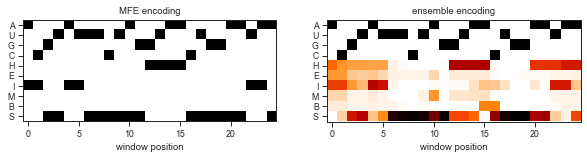

In [76]:
figure(figsize=(10,4))
subplot(1,2,1)
title('MFE encoding')
imshow(np.array(mea_inputs_train[33].reshape(25,10)).T,cmap='gist_heat_r')
yticks(range(10), ['A','U','G','C','H','E','I','M','B','S'])
xlabel('window position')
subplot(1,2,2)
title('ensemble encoding')
imshow(np.array(ens_inputs_train[33].reshape(25,10)).T,cmap='gist_heat_r')
yticks(range(10), ['A','U','G','C','H','E','I','M','B','S'])
xlabel('window position')

#### Setup kaggle submissions

In [57]:
sample_submission = pd.read_csv('sample_submission.csv.zip')
mask = sample_submission['id_seqpos'].isin(mea_test_labels)

In [58]:
ens_sample_submission = pd.read_csv('sample_submission.csv.zip')
mask = ens_sample_submission['id_seqpos'].isin(ens_test_labels)

#### Train models

###### MEA models

In [59]:
mea_models = {}

for output_type in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C','deg_50C']:
    mea_outputs_train, mea_outputs_labels = encode_output(kaggle_train, data_type=output_type)

    # Clip negative values to 0
    mea_outputs_train = np.clip(mea_outputs_train, 0, 100)

    reg = Ridge(alpha=0.15)
    print('Fitting %s ...' % output_type)
    reg.fit(mea_inputs_train, mea_outputs_train)
    
    mea_models[output_type] = reg
    
    # test inputs, add to sample submission df
    test_prediction = reg.predict(mea_inputs_test)
    sample_submission.loc[mask, output_type] = test_prediction

Fitting reactivity ...
Fitting deg_Mg_pH10 ...
Fitting deg_pH10 ...
Fitting deg_Mg_50C ...
Fitting deg_50C ...


###### Ensemble-averaged models

In [60]:
ens_models = {}

for output_type in ['reactivity', 'deg_Mg_pH10', 'deg_pH10', 'deg_Mg_50C','deg_50C']:
    ens_outputs_train, ens_outputs_labels = encode_output(kaggle_train, data_type=output_type)
    
    # Clip negative values to 0
    ens_outputs_train = np.clip(ens_outputs_train, 0, 100)

    reg = Ridge(alpha=0.15)
    print('Fitting %s ...' % output_type)
    reg.fit(ens_inputs_train, ens_outputs_train)
    
    ens_models[output_type] = reg
    
    # test inputs, add to sample submission df
    test_prediction = reg.predict(ens_inputs_test)
    ens_sample_submission.loc[mask, output_type] = test_prediction

Fitting reactivity ...
Fitting deg_Mg_pH10 ...
Fitting deg_pH10 ...
Fitting deg_Mg_50C ...
Fitting deg_50C ...


In [61]:
# save to csv
sample_submission.to_csv('test_mea_code_jan28.csv', index=False)
ens_sample_submission.to_csv('test_ens_code_jan28.csv', index=False)

## Using the existing class that contains "DegScore-2.1"

In [30]:
def score_mcrmse(models, test_df):
    scored_data_types = ['reactivity', 'deg_Mg_pH10', 'deg_Mg_50C']

    seq_scores = []
    for i, row in test_df.iterrows():
        scores = []
        for data_type in scored_data_types:
            model = models[data_type]
            
            coeffs = model.coef_
            inter = model.intercept_
            
            mdl = DegScore.DegScore(row['sequence'], structure=row['structure'], coeffs=coeffs, intercept=inter)
            
            seq_scored = row['seq_scored']
            pred = mdl.degscore_by_position[:seq_scored]
            target = np.array(json.loads(row[data_type])[:seq_scored])
            
            scores.extend(np.square(pred - target))
        
        seq_scores.append(scores)
        
    return np.mean(seq_scores)

In [31]:
score_mcrmse(mea_models, kaggle_test)

0.24691545925204095

In [32]:
score_mcrmse(ens_models, kaggle_test)

0.23856658661289426